In [ ]:
%pip -q install matplotlib pandas scikit-learn hdfs

In [2]:
import os, shutil, glob, io
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, col, when, sum as F_sum
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LogisticRegressionModel, RandomForestClassificationModel, GBTClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import FeatureHasher
from pyspark import SparkFiles
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image

In [3]:
# Stable local dir for Spark
local_dir = r"D:\spark-temp"
if not os.path.exists(local_dir):
    os.makedirs(local_dir)

# Clean old blockmgr before starting Spark
for d in glob.glob(os.path.join(local_dir, "blockmgr-*")):
    shutil.rmtree(d, ignore_errors=True)

# Créer une session Spark en mode local
spark = SparkSession.builder \
    .appName("ctr_prediction") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://OUARAS:9000") \
    .config("spark.local.dir", local_dir) \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.executor.cores", "2") \
    .config("spark.executor.instances", "2") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .master("local[8]") \
    .getOrCreate()

print("Spark Session démarrée")

Spark Session démarrée


In [4]:
spark

In [5]:
spark.conf.set("spark.sql.pivotMaxValues", 50000)

## Data Organization (HDFS : HADOOP FILE SYSTEM)

### HDFS Path

In [6]:
hdfs_path = "hdfs://OUARAS:9000/ctr_prediction/"
Data_path = f"{hdfs_path}Data/"
Models_path = f"{hdfs_path}Models/"
Output_path = f"{hdfs_path}Output/"

In [7]:
# Lecture des trois fichiers depuis HDFS
train_path = f"{Data_path}ctr_train.csv"
test_path = f"{Data_path}ctr_test.csv"
submission_path = f"{Data_path}ctr_sample_submission.csv"

In [8]:
# Lecture avec inférence de schéma
df_train = spark.read.csv(train_path, header=True, inferSchema=True)

# Vérification des données
print("=== TRAIN ===")
df_train.show(5)
df_train.printSchema()

=== TRAIN ===
+---+--------------------+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|idx|                  id|click|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|
+---+--------------------+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|  1| 1000009418151094273|    0|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22| a99f214a| ddd2926e|    44956a24|          1|               2|15706|320| 50|1722|  0| 35|    -1| 79|
|  2|10000169349117863715|    0|14102100|1005|         0|1fbe01fe|   f3845767|    

In [9]:
# Lecture avec inférence de schéma
df_test = spark.read.csv(test_path, header=True, inferSchema=True)

# Vérification rapide
print("=== TEST ===")
df_test.show(5)

=== TEST ===
+---+--------------------+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|idx|                  id|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|
+---+--------------------+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|  4|10000640724480838376|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22| a99f214a| e8275b8f|    6332421a|          1|               0|15706|320| 50|1722|  0| 35|100084| 79|
|  6|10000720757801103869|14102100|1005|         0|d6137915|   bb1ef334|     f028772b|ecad2386|  7801e8d9| 

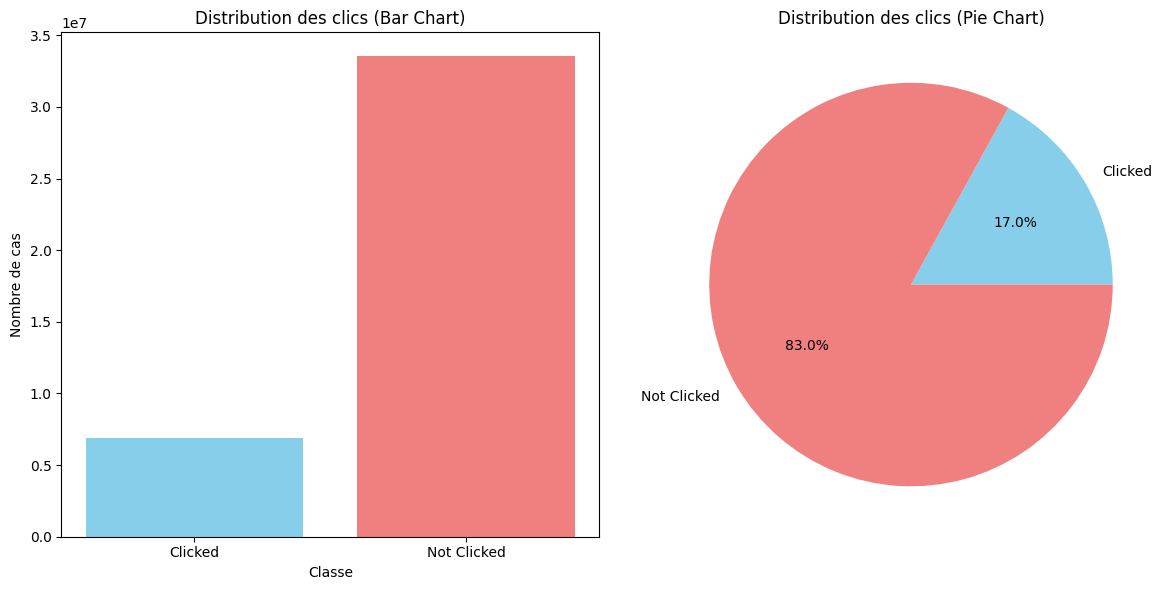

In [10]:
# Ajouter une colonne descriptive
df_click_status = df_train.withColumn(
    "Click_Status",
    when(col("click") == 1, "Clicked").otherwise("Not Clicked")
)

# Compter les occurrences
class_counts = (
    df_click_status.groupBy("Click_Status")
    .count()
    .orderBy("Click_Status")
    .collect()
)

# Transformer en listes Python
labels = [row["Click_Status"] for row in class_counts]
counts = [row["count"] for row in class_counts]

# Création des graphiques
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart
ax[0].bar(labels, counts, color=["skyblue", "lightcoral"])
ax[0].set_title("Distribution des clics (Bar Chart)")
ax[0].set_xlabel("Classe")
ax[0].set_ylabel("Nombre de cas")

# Pie chart
ax[1].pie(counts, labels=labels, autopct="%1.1f%%", colors=["skyblue", "lightcoral"])
ax[1].set_title("Distribution des clics (Pie Chart)")

plt.tight_layout()
plt.show()

In [11]:
# Colonnes inutiles
cols_to_drop = ["idx", "id", "device_id", "device_ip"]

# Nettoyage du train
train_data_clean = (
    df_train
    .dropna()  # Supprimer toutes les lignes avec NaN / null
    .drop(*cols_to_drop)  # Supprimer colonnes inutiles
    .withColumnRenamed("click", "label")  # Renommer la cible
)

# Nettoyage du test
test_data_clean = (
    df_test
    .dropna()
    .drop(*cols_to_drop)
)

# Vérification
print("Train set :")
print(f"Lignes : {train_data_clean.count()}, Colonnes : {len(train_data_clean.columns)}")
print("Test set :")
print(f"Lignes : {test_data_clean.count()}, Colonnes : {len(test_data_clean.columns)}")

# Aperçu
train_data_clean.show(5)


Train set :
Lignes : 159968, Colonnes : 21
Test set :
Lignes : 40032, Colonnes : 20
+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|label|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|
+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|    0|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22|    44956a24|          1|               2|15706|320| 50|1722|  0| 35|    -1| 79|
|    0|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22|    711ee120|          1|               0|15704|320| 50|1722|  0| 35|100084| 79|
|    0|1410

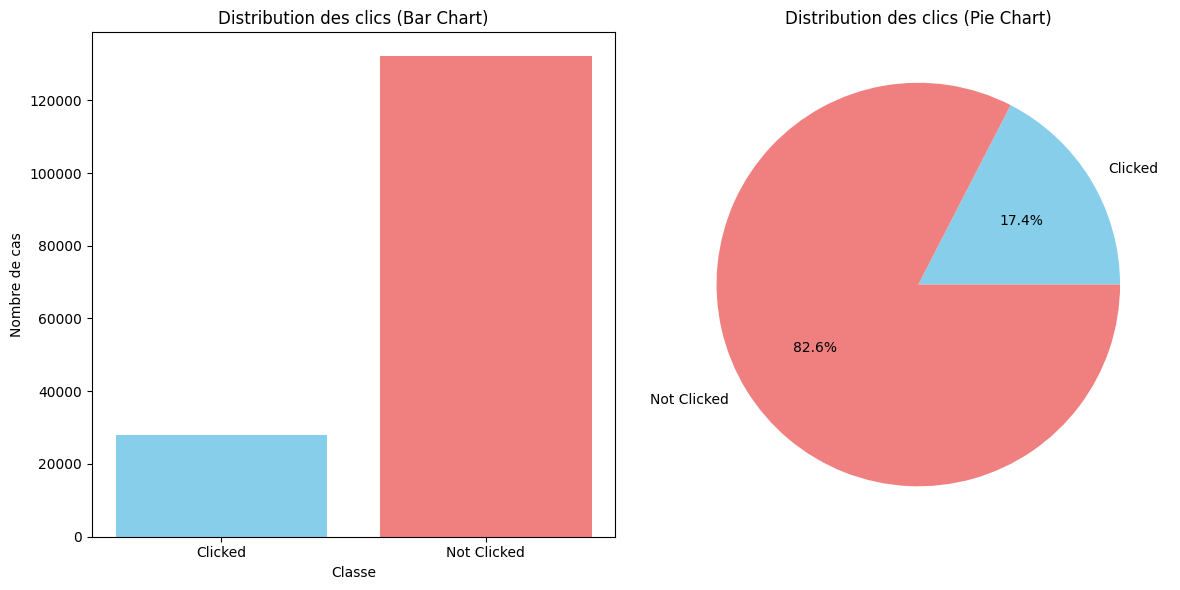

In [12]:
# Ajouter une colonne descriptive
df_click_status = train_data_clean.withColumn(
    "Click_Status",
    when(col("label") == 1, "Clicked").otherwise("Not Clicked")
)

# Compter les occurrences
class_counts = (
    df_click_status.groupBy("Click_Status")
    .count()
    .orderBy("Click_Status")
    .collect()
)

# Transformer en listes Python
labels = [row["Click_Status"] for row in class_counts]
counts = [row["count"] for row in class_counts]

# Création des graphiques
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart
ax[0].bar(labels, counts, color=["skyblue", "lightcoral"])
ax[0].set_title("Distribution des clics (Bar Chart)")
ax[0].set_xlabel("Classe")
ax[0].set_ylabel("Nombre de cas")

# Pie chart
ax[1].pie(counts, labels=labels, autopct="%1.1f%%", colors=["skyblue", "lightcoral"])
ax[1].set_title("Distribution des clics (Pie Chart)")

plt.tight_layout()
plt.show()

In [13]:
# Compter les classes
count_clicked = df_click_status.filter(col("Click_Status") == "Clicked").count()
count_not_clicked = df_click_status.filter(col("Click_Status") == "Not Clicked").count()

# Calcul du ratio inverse
ratio = count_clicked / count_not_clicked

# Sous-échantillonnage des majoritaires
not_clicked_undersampled = df_click_status.filter(col("Click_Status") == "Not Clicked").sample(
    withReplacement=False, fraction=ratio, seed=42
)

# Union des deux classes
balanced_df = not_clicked_undersampled.union(
    df_click_status.filter(col("Click_Status") == "Clicked")
)

print("Dataset équilibré :", balanced_df.count(), "lignes")


Dataset équilibré : 55969 lignes


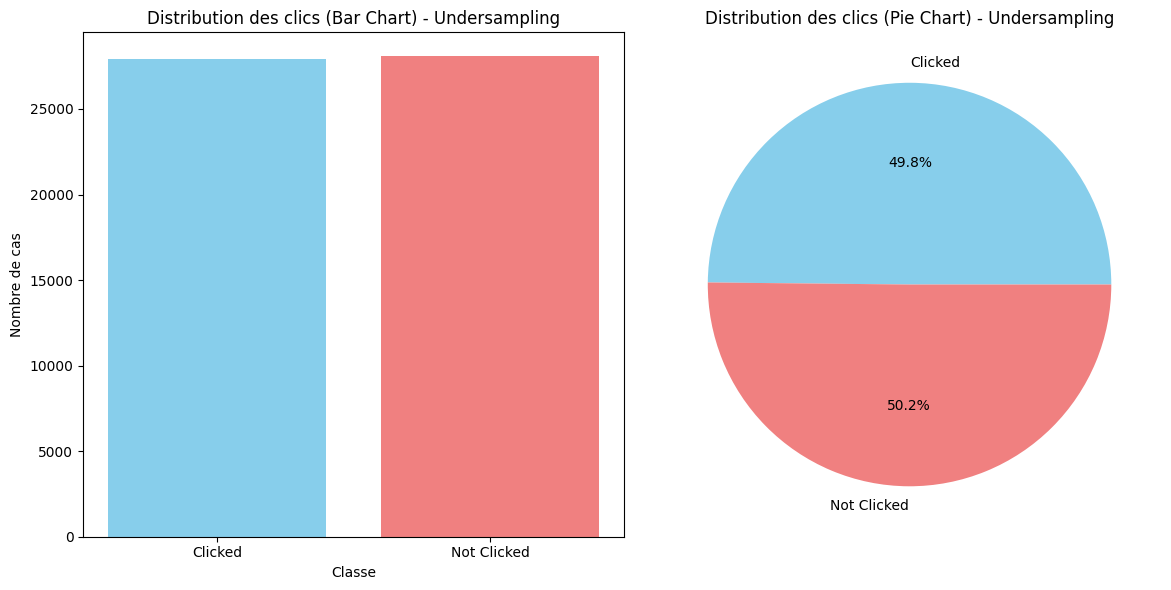

In [14]:
def plot_click_distribution(df, title):
    # Ajouter une colonne descriptive
    df_click_status = df.withColumn(
        "Click_Status",
        when(col("label") == 1, "Clicked").otherwise("Not Clicked")
    )

    # Compter les occurrences
    class_counts = (
        df_click_status.groupBy("Click_Status")
        .count()
        .orderBy("Click_Status")
        .collect()
    )

    # Transformer en listes Python
    labels = [row["Click_Status"] for row in class_counts]
    counts = [row["count"] for row in class_counts]

    # Création des graphiques
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Bar chart
    ax[0].bar(labels, counts, color=["skyblue", "lightcoral"])
    ax[0].set_title(f"Distribution des clics (Bar Chart) - {title}")
    ax[0].set_xlabel("Classe")
    ax[0].set_ylabel("Nombre de cas")

    # Pie chart
    ax[1].pie(counts, labels=labels, autopct="%1.1f%%", colors=["skyblue", "lightcoral"])
    ax[1].set_title(f"Distribution des clics (Pie Chart) - {title}")

    plt.tight_layout()
    plt.show()


# Exemple d'utilisation :
plot_click_distribution(balanced_df, "Undersampling")

In [15]:
categorical_cols = [
    "site_id", "site_domain", "site_category",
    "app_id", "app_domain", "app_category",
    "device_model"
]
numeric_cols = [
    "hour", "C1", "banner_pos", "device_type", "device_conn_type",
    "C14", "C15", "C16", "C17", "C18", "C19", "C20", "C21"
]
target_col = "label"

In [16]:
hasher = FeatureHasher(
    inputCols=categorical_cols,
    outputCol="hashed_features",
    numFeatures=2**16  # ajuster selon mémoire
)

In [17]:
assembler = VectorAssembler(
    inputCols=numeric_cols + ["hashed_features"],  # ou one-hot features
    outputCol="features"
)


In [18]:
pipeline = Pipeline(stages=[hasher, assembler])
model = pipeline.fit(balanced_df)

train_df_transformed = model.transform(balanced_df)
train_df_transformed.select("features", target_col).show(5, truncate=False)

test_df_transformed = model.transform(test_data_clean)
test_df_transformed.select("features").show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                           |label|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|(65549,[0,1,2,3,5,6,7,8,9,10,11,12,345,6522,21214,23905,27031,40718,46345],[1.41021E7,1005.0,1.0,1.0,17747.0,320.0,50.0,1974.0,2.0,39.0,100019.0,33.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|0    |
|(65549,[0,1,3,5,6,7,8,10,11,12,345,2686,2794,37764,40718,44106,46345],[1.41021E7,1005.0,1.0,20366.0,320.0,50.0,2333.0,39.0,-1.0,157.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                |0    |
|(65549,[0,1,2,3,5,6,7,8,10,11,12,345,21214,23905,27031,4071

In [19]:
train_df_transformed.show()

+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+------------+--------------------+--------------------+
|label|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|Click_Status|     hashed_features|            features|
+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+------------+--------------------+--------------------+
|    0|14102100|1005|         1|e151e245|   7e091613|     f028772b|ecad2386|  7801e8d9|    07d7df22|    8f5c9827|          1|               0|17747|320| 50|1974|  2| 39|100019| 33| Not Clicked|(65536,[332,6509,...|(65549,[0,1,2,3,5...|
|    0|14102100|1005|         0|543a539e|   c7ca3108|   

In [20]:
test_df_transformed.show()

+--------+----+----------+--------+-----------+-------------+--------+----------+------------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+--------------------+--------------------+
|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|     hashed_features|            features|
+--------+----+----------+--------+-----------+-------------+--------+----------+------------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+--------------------+--------------------+
|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22|    6332421a|          1|               0|15706|320| 50|1722|  0| 35|100084| 79|(65536,[332,1085,...|(65549,[0,1,3,5,6...|
|14102100|1005|         0|d6137915|   bb1ef334|     f028772b|ecad2386|  7801e8d9|    07d7df22|    8a4875bd|          1|             

In [21]:
train_df_transformed = train_df_transformed.repartition(50)
test_df_transformed = test_df_transformed.repartition(50)

In [22]:
model_lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)
model_name_lr = "LogisticRegression"

model_rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=50)
model_name_rf = "RandomForest"

results = {}

# Logistic Regression

In [24]:
# Cross-validation
tvs_lr = TrainValidationSplit(
    estimator=model_lr,
    estimatorParamMaps=ParamGridBuilder().build(),
    evaluator=BinaryClassificationEvaluator(
        labelCol="label", 
        rawPredictionCol="rawPrediction", 
        metricName="areaUnderROC"
    ),
    trainRatio=0.8,
    parallelism=1
)

In [25]:
cv_model_lr = tvs_lr.fit(train_df_transformed)

In [26]:
# Sauvegarde du modèle sur HDFS
cv_model_lr.bestModel.write().overwrite().save(f"{Models_path}{model_name_lr}")

In [27]:
# Prédictions sur le test
pred = cv_model_lr.transform(test_df_transformed)

In [29]:
# Utiliser le set d'entraînement transformé pour ROC/AUC
pred_train = cv_model_lr.transform(train_df_transformed)

# Récupérer les labels et scores pour sklearn
y_true = np.array([row['label'] for row in pred_train.select('label').collect()])
y_scores = np.array([row['probability'][1] for row in pred_train.select('probability').collect()])

# ROC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
results[model_name_lr] = {"fpr": fpr, "tpr": tpr, "auc": roc_auc, "y_true": y_true, "y_scores": y_scores}

# Plot ROC et sauvegarde locale
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {model_name_lr}')
plt.legend(loc="lower right")

local_roc_path = f"D:/temp/ROC_{model_name_lr}.png"  # dossier temporaire local
plt.savefig(local_roc_path)
plt.close()

In [30]:
# Copier sur HDFS
hdfs_roc_path = f"{Output_path}ROC_{model_name_lr}.png"

# S'assurer que Spark connaît la config HDFS
spark.sparkContext._jsc.hadoopConfiguration().set("dfs.client.use.datanode.hostname", "true")

# Utiliser l'API Java Hadoop pour copier le fichier
fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())

src_path = spark._jvm.org.apache.hadoop.fs.Path(local_roc_path)  # chemin local
dst_path = spark._jvm.org.apache.hadoop.fs.Path(hdfs_roc_path)   # chemin HDFS

# True = supprimer la source après copie, True = overwrite
fs.copyFromLocalFile(False, True, src_path, dst_path)

print(f"✅ Fichier ROC sauvegardé sur HDFS : {hdfs_roc_path}")


✅ Fichier ROC sauvegardé sur HDFS : hdfs://OUARAS:9000/ctr_prediction/Output/ROC_LogisticRegression.png


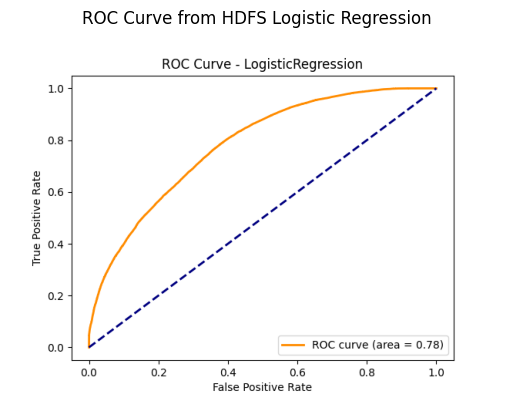

In [31]:
# --- Récupérer le fichier depuis HDFS ---
spark.sparkContext._jsc.hadoopConfiguration().set("dfs.client.use.datanode.hostname", "true")
fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())

hdfs_path = f"{Output_path}ROC_LogisticRegression.png"
path = spark._jvm.org.apache.hadoop.fs.Path(hdfs_path)

# Lire le flux du fichier HDFS
stream = fs.open(path)
data = bytearray()
b = stream.read()
while b != -1:
    data.append(b)
    b = stream.read()
stream.close()

# --- Charger et afficher l'image ---
image = Image.open(io.BytesIO(data))
plt.imshow(image)
plt.axis('off')
plt.title("ROC Curve from HDFS Logistic Regression")
plt.show()


In [32]:
# Confusion Matrix
y_pred_label = (y_scores >= 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - {model_name_lr}')

local_cm_path = f"D:/temp/ConfMatrix_{model_name_lr}.png"
plt.savefig(local_cm_path)
plt.close()

In [33]:
# Copier la matrice de confusion sur HDFS
hdfs_cm_path = f"{Output_path}ConfMatrix_{model_name_lr}.png"

fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
src_cm_path = spark._jvm.org.apache.hadoop.fs.Path(local_cm_path)
dst_cm_path = spark._jvm.org.apache.hadoop.fs.Path(hdfs_cm_path)

fs.copyFromLocalFile(False, True, src_cm_path, dst_cm_path)

print(f"✅ Fichier matrice de confusion sauvegardé sur HDFS : {hdfs_cm_path}")

✅ Fichier matrice de confusion sauvegardé sur HDFS : hdfs://OUARAS:9000/ctr_prediction/Output/ConfMatrix_LogisticRegression.png


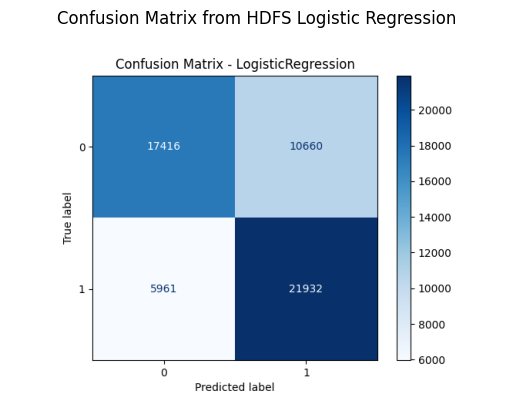

In [34]:
# --- Récupérer le fichier matrice de confusion depuis HDFS ---
fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
cm_hdfs_path = f"{Output_path}ConfMatrix_{model_name_lr}.png"
cm_path = spark._jvm.org.apache.hadoop.fs.Path(cm_hdfs_path)

stream = fs.open(cm_path)
cm_data = bytearray()
b = stream.read()
while b != -1:
    cm_data.append(b)
    b = stream.read()
stream.close()

# --- Charger et afficher l'image ---
cm_image = Image.open(io.BytesIO(cm_data))
plt.imshow(cm_image)
plt.axis('off')
plt.title("Confusion Matrix from HDFS Logistic Regression")
plt.show()

In [36]:
# 1️⃣ Charger le modèle entraîné depuis HDFS
model_path_lr = f"{Models_path}{model_name_lr}"
loaded_model_lr = LogisticRegressionModel.load(model_path_lr)

# 2️⃣ Utiliser le test set pour la prédiction de soumission
print("=== TEST SET POUR SOUMISSION ===")
df_test.show(5)

# 3️⃣ Transformer les features du test set
test_features_for_submit = model.transform(df_test)

# 4️⃣ Appliquer le modèle sur les données
predictions = loaded_model_lr.transform(test_features_for_submit)

# 5️⃣ Récupérer la prédiction binaire (0 ou 1)
predictions = predictions.withColumn("click", predictions.prediction.cast("integer"))

# 6️⃣ Sélectionner idx + click pour soumission
df_result_lr = predictions.select("idx", "click")

print("=== SUBMISSION APRÈS PREDICTION ===")
df_result_lr.show(5)

# 7️⃣ Sauvegarder la soumission prédite sur HDFS
output_submission_path = f"{Output_path}submission_with_logistic_regression.csv"
df_result_lr.write.csv(output_submission_path, header=True, mode="overwrite")

=== TEST SET POUR SOUMISSION ===
+---+--------------------+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|idx|                  id|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|
+---+--------------------+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|  4|10000640724480838376|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22| a99f214a| e8275b8f|    6332421a|          1|               0|15706|320| 50|1722|  0| 35|100084| 79|
|  6|10000720757801103869|14102100|1005|         0|d6137915|   bb1ef334|     f028772b|e

In [37]:
# Vérification des NaN dans la soumission LR
nan_counts = df_result_lr.select([isnan(col(c)).cast("int").alias(c) for c in df_result_lr.columns]) \
    .agg(*(F_sum(col(c)).alias(c) for c in df_result_lr.columns)) \
    .collect()[0]

total_nan_count_lr = sum(nan_counts)

if total_nan_count_lr > 0:
    print("Des valeurs NaN ont été détectées dans le DataFrame de soumission. Veuillez vérifier les données.")
else:
    print("Aucune valeur NaN détectée dans le DataFrame de soumission.")

Aucune valeur NaN détectée dans le DataFrame de soumission.


# Random Forest Classifier

In [38]:
# Cross-validation
tvs_rf = TrainValidationSplit(
    estimator=model_rf,
    estimatorParamMaps=ParamGridBuilder().build(),
    evaluator=BinaryClassificationEvaluator(
        labelCol="label", 
        rawPredictionCol="rawPrediction", 
        metricName="areaUnderROC"
    ),
    trainRatio=0.8,
    parallelism=1
)

In [39]:
cv_model_rf = tvs_rf.fit(train_df_transformed)

In [40]:
# Sauvegarde du modèle sur HDFS
cv_model_rf.bestModel.write().overwrite().save(f"{Models_path}{model_name_rf}")

In [41]:
# Prédictions sur le test
pred = cv_model_rf.transform(test_df_transformed)

In [43]:
# Utiliser le set d'entraînement transformé pour ROC/AUC
pred_train_rf = cv_model_rf.transform(train_df_transformed)
y_true = np.array([row['label'] for row in pred_train_rf.select('label').collect()])
y_scores = np.array([row['probability'][1] for row in pred_train_rf.select('probability').collect()])

# ROC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
results[model_name_rf] = {"fpr": fpr, "tpr": tpr, "auc": roc_auc, "y_true": y_true, "y_scores": y_scores}

# Plot ROC et sauvegarde locale
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {model_name_rf}')
plt.legend(loc="lower right")

local_roc_path_rf = f"D:/temp/ROC_{model_name_rf}.png"  # dossier temporaire local
plt.savefig(local_roc_path_rf)
plt.close()

In [44]:
# Copier sur HDFS
hdfs_roc_path_rf = f"{Output_path}ROC_{model_name_rf}.png"

# S'assurer que Spark connaît la config HDFS
spark.sparkContext._jsc.hadoopConfiguration().set("dfs.client.use.datanode.hostname", "true")

# Utiliser l'API Java Hadoop pour copier le fichier
fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())

src_path = spark._jvm.org.apache.hadoop.fs.Path(local_roc_path_rf)  # chemin local
dst_path = spark._jvm.org.apache.hadoop.fs.Path(hdfs_roc_path_rf)   # chemin HDFS

# True = supprimer la source après copie, True = overwrite
fs.copyFromLocalFile(False, True, src_path, dst_path)

print(f"✅ Fichier ROC sauvegardé sur HDFS : {hdfs_roc_path_rf}")


✅ Fichier ROC sauvegardé sur HDFS : hdfs://OUARAS:9000/ctr_prediction/Output/ROC_RandomForest.png


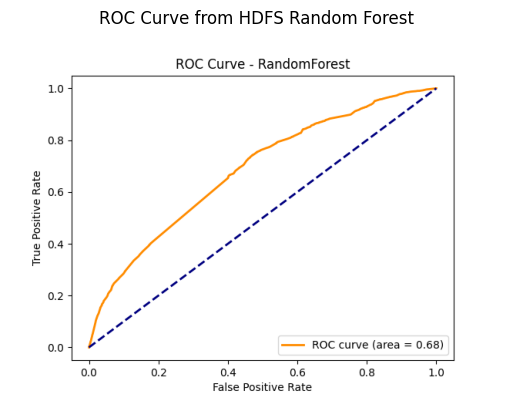

In [45]:
# --- Récupérer le fichier depuis HDFS ---
spark.sparkContext._jsc.hadoopConfiguration().set("dfs.client.use.datanode.hostname", "true")
fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())

hdfs_path_rf = f"{Output_path}ROC_{model_name_rf}.png"
path = spark._jvm.org.apache.hadoop.fs.Path(hdfs_path_rf)

# Lire le flux du fichier HDFS
stream = fs.open(path)
data = bytearray()
b = stream.read()
while b != -1:
    data.append(b)
    b = stream.read()
stream.close()

# --- Charger et afficher l'image ---
image = Image.open(io.BytesIO(data))
plt.imshow(image)
plt.axis('off')
plt.title("ROC Curve from HDFS Random Forest")
plt.show()


In [46]:
# Confusion Matrix
y_pred_label = (y_scores >= 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred_label)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - {model_name_rf}')

local_cm_path_rf = f"D:/temp/ConfMatrix_{model_name_rf}.png"
plt.savefig(local_cm_path_rf)
plt.close()

In [47]:
# Copier la matrice de confusion sur HDFS
hdfs_cm_path_rf = f"{Output_path}ConfMatrix_{model_name_rf}.png"

fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
src_cm_path = spark._jvm.org.apache.hadoop.fs.Path(local_cm_path_rf)
dst_cm_path = spark._jvm.org.apache.hadoop.fs.Path(hdfs_cm_path_rf)

fs.copyFromLocalFile(False, True, src_cm_path, dst_cm_path)

print(f"✅ Fichier matrice de confusion sauvegardé sur HDFS : {hdfs_cm_path_rf}")

✅ Fichier matrice de confusion sauvegardé sur HDFS : hdfs://OUARAS:9000/ctr_prediction/Output/ConfMatrix_RandomForest.png


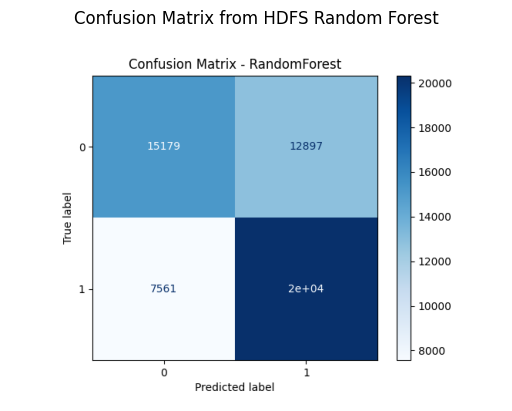

In [48]:
# --- Récupérer le fichier matrice de confusion depuis HDFS ---
fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
cm_hdfs_path_rf = f"{Output_path}ConfMatrix_{model_name_rf}.png"
cm_path = spark._jvm.org.apache.hadoop.fs.Path(cm_hdfs_path_rf)

stream = fs.open(cm_path)
cm_data = bytearray()
b = stream.read()
while b != -1:
    cm_data.append(b)
    b = stream.read()
stream.close()

# --- Charger et afficher l'image ---
cm_image = Image.open(io.BytesIO(cm_data))
plt.imshow(cm_image)
plt.axis('off')
plt.title("Confusion Matrix from HDFS Random Forest")
plt.show()

In [50]:
# 1️⃣ Charger le modèle Random Forest entraîné depuis HDFS

model_path_rf = f"{Models_path}{model_name_rf}"
loaded_model_rf = RandomForestClassificationModel.load(model_path_rf)

# 2️⃣ Utiliser le test set pour la prédiction de soumission
print("=== TEST SET POUR SOUMISSION (RF) ===")
test_data_clean.show(5)

# 3️⃣ Transformer les features du test set
test_features_for_submit_rf = model.transform(test_data_clean)

# 4️⃣ Appliquer le modèle sur les données
predictions_rf = loaded_model_rf.transform(test_features_for_submit_rf)

# 5️⃣ Récupérer la prédiction binaire (0 ou 1)
predictions_rf = predictions_rf.withColumn("click", predictions_rf.prediction.cast("integer"))

# 6️⃣ Sélectionner idx + click pour soumission
# Joindre avec df_test pour récupérer la colonne idx
df_result_rf = df_test.select("idx").join(
	predictions_rf.select("click"), 
	how="inner"
)

print("=== SUBMISSION APRÈS PREDICTION (RF) ===")
df_result_rf.show(5)

# 7️⃣ Sauvegarder la soumission prédite sur HDFS
output_submission_path_rf = f"{Output_path}submission_with_random_forest.csv"
df_result_rf.write.csv(output_submission_path_rf, header=True, mode="overwrite")

=== TEST SET POUR SOUMISSION (RF) ===
+--------+----+----------+--------+-----------+-------------+--------+----------+------------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|
+--------+----+----------+--------+-----------+-------------+--------+----------+------------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22|    6332421a|          1|               0|15706|320| 50|1722|  0| 35|100084| 79|
|14102100|1005|         0|d6137915|   bb1ef334|     f028772b|ecad2386|  7801e8d9|    07d7df22|    8a4875bd|          1|               0|16920|320| 50|1899|  0|431|100077|117|
|14102100|1005|         0|9e8cf15d|   0d3cb7be|     f028772b|ecad2386|  7801e8d9|    07

In [51]:
# Vérification des NaN dans la soumission RF
nan_counts_rf = df_result_rf.select([isnan(col(c)).cast("int").alias(c) for c in df_result_rf.columns]) \
    .agg(*(F_sum(col(c)).alias(c) for c in df_result_rf.columns)) \
    .collect()[0]

total_nan_count_rf = sum(nan_counts_rf)

if total_nan_count_rf > 0:
    print("Des valeurs NaN ont été détectées dans le DataFrame de soumission. Veuillez vérifier les données.")
else:
    print("Aucune valeur NaN détectée dans le DataFrame de soumission.")

Aucune valeur NaN détectée dans le DataFrame de soumission.


# MLP Classifier

In [23]:
from pyspark.ml.classification import MultilayerPerceptronClassifier, MultilayerPerceptronClassificationModel

# Définir les couches du MLP (entrée, cachées, sortie)
input_size = train_df_transformed.select("features").first()["features"].size
layers = [input_size, 128, 64, 2]  # 2 classes en sortie

model_mlp = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="label",
    maxIter=50,
    layers=layers,
    blockSize=128,
    seed=42
)
model_name_mlp = "MLP"

In [24]:
# Cross-validation
tvs_mlp = TrainValidationSplit(
    estimator=model_mlp,
    estimatorParamMaps=ParamGridBuilder().build(),
    evaluator=BinaryClassificationEvaluator(
        labelCol="label", 
        rawPredictionCol="rawPrediction", 
        metricName="areaUnderROC"
    ),
    trainRatio=0.8,
    parallelism=1
)

In [ ]:
cv_model_mlp = tvs_mlp.fit(train_df_transformed)

In [ ]:
# Sauvegarde du modèle sur HDFS
cv_model_mlp.bestModel.write().overwrite().save(f"{Models_path}{model_name_mlp}")

In [ ]:
# Prédictions sur le test
pred_mlp = cv_model_mlp.transform(test_df_transformed)

In [ ]:
# Utiliser le set d'entraînement transformé pour ROC/AUC
pred_train_mlp = cv_model_mlp.transform(train_df_transformed)
y_true_mlp = np.array([row['label'] for row in pred_train_mlp.select('label').collect()])
y_scores_mlp = np.array([row['probability'][1] for row in pred_train_mlp.select('probability').collect()])

# ROC
fpr_mlp, tpr_mlp, _ = roc_curve(y_true_mlp, y_scores_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
results[model_name_mlp] = {"fpr": fpr_mlp, "tpr": tpr_mlp, "auc": roc_auc_mlp, "y_true": y_true_mlp, "y_scores": y_scores_mlp}

# Plot ROC et sauvegarde locale
plt.figure()
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_mlp:.2f})')
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {model_name_mlp}')
plt.legend(loc="lower right")

local_roc_path_mlp = f"D:/temp/ROC_{model_name_mlp}.png"
plt.savefig(local_roc_path_mlp)
plt.close()

In [ ]:
# Copier sur HDFS
hdfs_roc_path_mlp = f"{Output_path}ROC_{model_name_mlp}.png"
fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
src_path_mlp = spark._jvm.org.apache.hadoop.fs.Path(local_roc_path_mlp)
dst_path_mlp = spark._jvm.org.apache.hadoop.fs.Path(hdfs_roc_path_mlp)
fs.copyFromLocalFile(False, True, src_path_mlp, dst_path_mlp)
print(f"✅ Fichier ROC sauvegardé sur HDFS : {hdfs_roc_path_mlp}")

In [ ]:
# Confusion Matrix
y_pred_label_mlp = (y_scores_mlp >= 0.5).astype(int)
cm_mlp = confusion_matrix(y_true_mlp, y_pred_label_mlp)
disp_mlp = ConfusionMatrixDisplay(cm_mlp)
disp_mlp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - {model_name_mlp}')

local_cm_path_mlp = f"D:/temp/ConfMatrix_{model_name_mlp}.png"
plt.savefig(local_cm_path_mlp)
plt.close()

In [ ]:
# Copier la matrice de confusion sur HDFS
hdfs_cm_path_mlp = f"{Output_path}ConfMatrix_{model_name_mlp}.png"
src_cm_path_mlp = spark._jvm.org.apache.hadoop.fs.Path(local_cm_path_mlp)
dst_cm_path_mlp = spark._jvm.org.apache.hadoop.fs.Path(hdfs_cm_path_mlp)
fs.copyFromLocalFile(False, True, src_cm_path_mlp, dst_cm_path_mlp)
print(f"✅ Fichier matrice de confusion sauvegardé sur HDFS : {hdfs_cm_path_mlp}")

In [ ]:
# Soumission
model_path_mlp = f"{Models_path}{model_name_mlp}"
loaded_model_mlp = MultilayerPerceptronClassificationModel.load(model_path_mlp)
test_features_for_submit_mlp = model.transform(test_data_clean)
predictions_mlp = loaded_model_mlp.transform(test_features_for_submit_mlp)
predictions_mlp = predictions_mlp.withColumn("click", predictions_mlp.prediction.cast("integer"))
df_result_mlp = df_test.select("idx").join(
    predictions_mlp.select("click"),
    how="inner"
)
output_submission_path_mlp = f"{Output_path}submission_with_mlp.csv"
df_result_mlp.write.csv(output_submission_path_mlp, header=True, mode="overwrite")